/tmp/ipykernel_4314/4167583300.py:111: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  axs[i].imshow(im, vmax=perc)


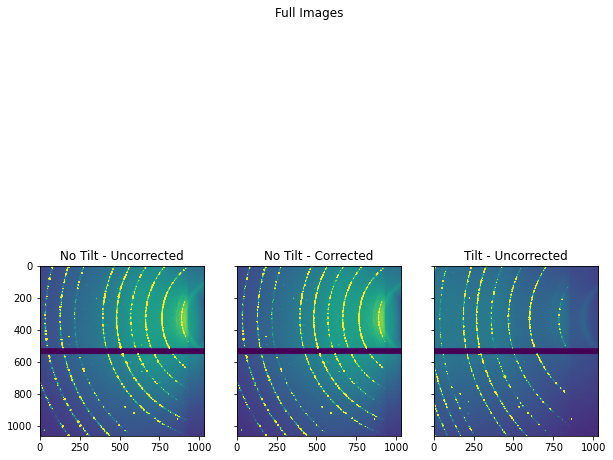

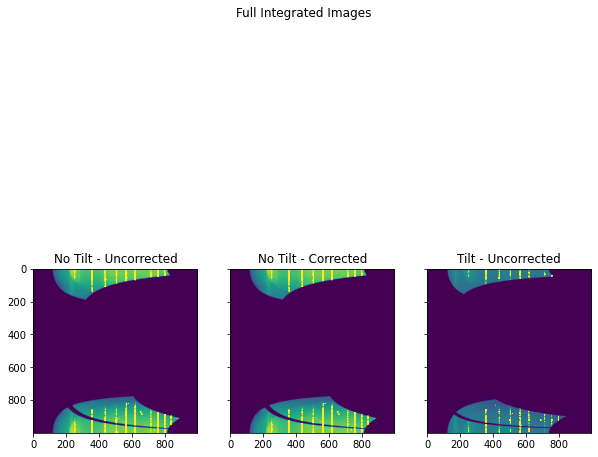

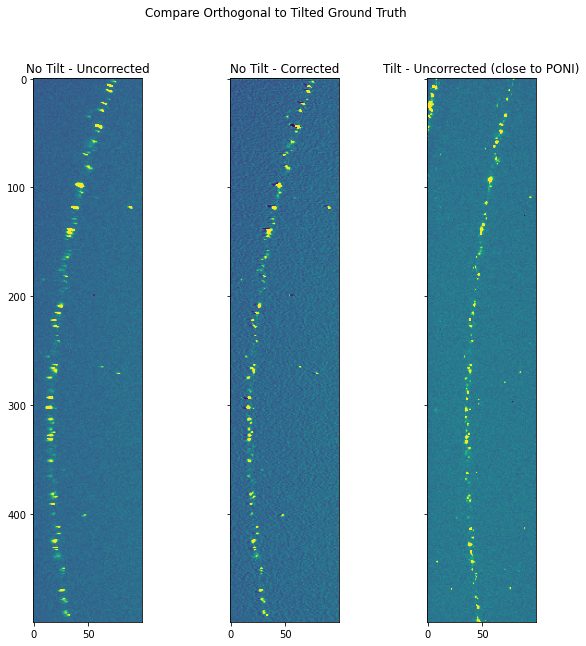

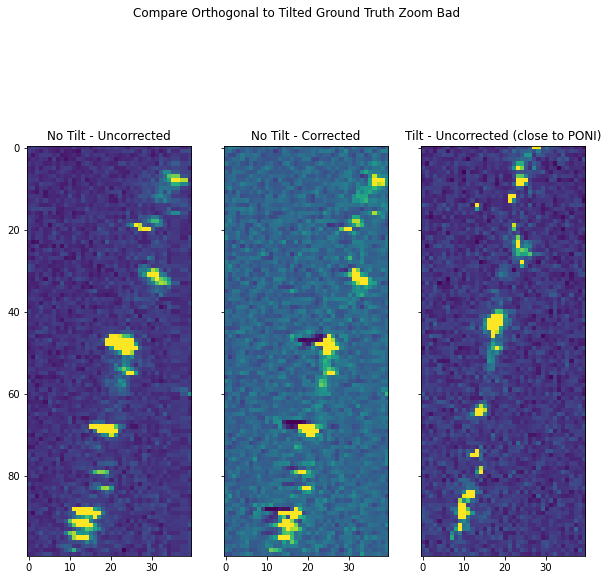

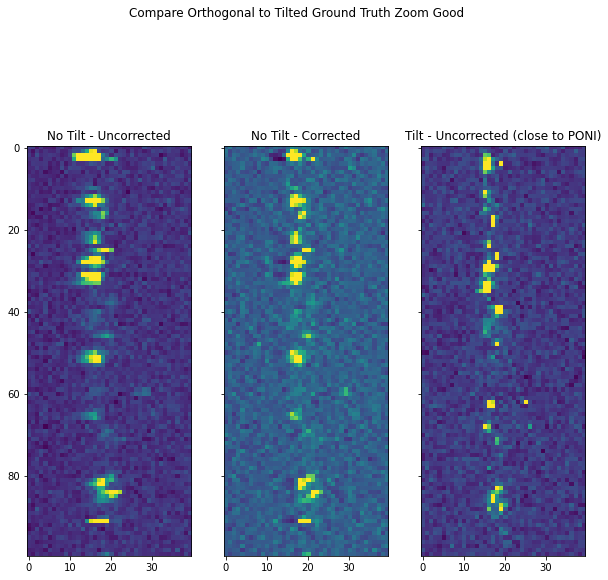

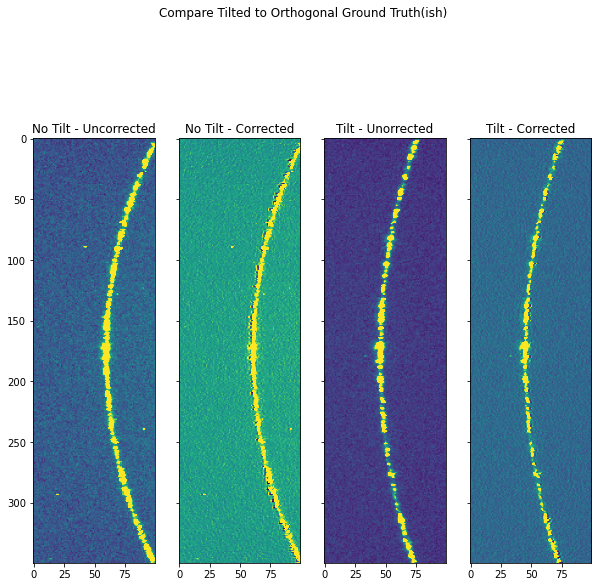

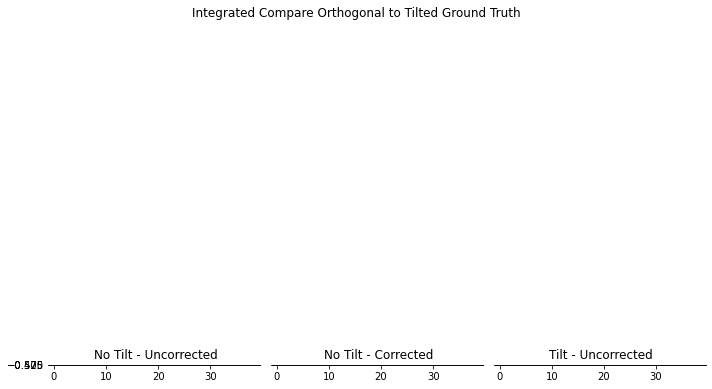

In [3]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os 
import numpy as np
import matplotlib.pyplot as plt

import examplesetup
import lib.deconvolution as deconvolution
import lib.utils as utils
import lib.xtrace as xtrace

project_dir = '/data/visitors/balder/20220115/2022022408'
experiment_dir = os.path.join(project_dir, 'raw/XRD Eiger Test')
poni_dir = os.path.join(project_dir, 'process')

stacks = {
    "no_tilt_close": {
        "filename": 'LaB6_9_data_000001.h5',
        "poni": 'samuel_9_0.poni'
    },
    "large_tilt_close": {
       "filename": 'LaB6_10_data_000001.h5',
       "poni": 'samuel_10_0.poni'
    },
    #"small_tilt_close": {
    #    "filename": 'LaB6_11_data_000001.h5',
    #    "poni": 'samuel_11_0.poni'
    #},
    #"no_tilt_far": {
    #    "filename": 'LaB6_13_data_000001.h5',
    #    "poni": 'samuel_13_0.poni'
    #}
}

az_npt = 2000
data_layer = 9
radial = (0, 60)
saves = {}

for stack_name in stacks.keys():
    stack = stacks[stack_name]
    config, data = utils.load_stack(
        os.path.join(project_dir, experiment_dir, stack["filename"]),
        os.path.join(poni_dir, stack["poni"]),
    )
    img, mask = utils.mask(data[data_layer], False)
    integrator = utils.azimutal_integrator(config)
    
    ray_grid = utils.ray_grid(config["dimensions"])
    G = xtrace.depth_spill_psf(config, *ray_grid)
    recovered_img = deconvolution.richard_lucy(img, G, 10)
    
    integrated_img = integrator.integrate2d(img, az_npt, az_npt, radial_range=radial)[0]
    integrated_recovered = integrator.integrate2d(recovered_img, az_npt, az_npt, radial_range=radial)[0]
    saves[stack_name] = {
        "original_image": img,
        "recovered_image": recovered_img,
        "original_integrated": integrated_img,
        "recovered_integrated": integrated_recovered 
    }
    
comparisons = {
    "Full Images": {
        "No Tilt - Uncorrected": { "source": "no_tilt_close", "image": "original_image", "area": (slice(0,-1), slice(0,-1)) },
        "No Tilt - Corrected": { "source": "no_tilt_close", "image": "recovered_image", "area": (slice(0,-1), slice(0,-1)) },
        "Tilt - Uncorrected": { "source": "large_tilt_close", "image": "original_image", "area": (slice(0,-1), slice(0,-1)) },
    },
    "Full Integrated Images": {
        "No Tilt - Uncorrected": { "source": "no_tilt_close", "image": "original_integrated", "area": (slice(0,-1), slice(0,-1)) },
        "No Tilt - Corrected": { "source": "no_tilt_close", "image": "recovered_integrated", "area": (slice(0,-1), slice(0,-1)) },
        "Tilt - Uncorrected": { "source": "large_tilt_close", "image": "original_integrated", "area": (slice(0,-1), slice(0,-1)) },
    },
    "Compare Orthogonal to Tilted Ground Truth": {
        "No Tilt - Uncorrected": { "source": "no_tilt_close", "image": "original_image", "area": (slice(0,500), slice(200,300)) },
        "No Tilt - Corrected": { "source": "no_tilt_close", "image": "recovered_image", "area": (slice(0,500), slice(200,300)) },
        "Tilt - Uncorrected (close to PONI)": { "source": "large_tilt_close", "image": "original_image", "area": (slice(0,500), slice(0,100)) },
    },
    "Compare Orthogonal to Tilted Ground Truth Zoom Bad": {
        "No Tilt - Uncorrected": { "source": "no_tilt_close", "image": "original_image", "area": (slice(50,150), slice(220,260)) },
        "No Tilt - Corrected": { "source": "no_tilt_close", "image": "recovered_image", "area": (slice(50,150), slice(220,260)) },
        "Tilt - Uncorrected (close to PONI)": { "source": "large_tilt_close", "image": "original_image", "area": (slice(50,150), slice(40,80)) },
    },
    "Compare Orthogonal to Tilted Ground Truth Zoom Good": {
        "No Tilt - Uncorrected": { "source": "no_tilt_close", "image": "original_image", "area": (slice(300,400), slice(200,240)) },
        "No Tilt - Corrected": { "source": "no_tilt_close", "image": "recovered_image", "area": (slice(300,400), slice(200,240)) },
        "Tilt - Uncorrected (close to PONI)": { "source": "large_tilt_close", "image": "original_image", "area": (slice(300,400), slice(20,60)) },
    },
    "Compare Tilted to Orthogonal Ground Truth(ish)": {
        "No Tilt - Uncorrected": { "source": "no_tilt_close", "image": "original_image", "area": (slice(150,500), slice(700,800)) },
        "No Tilt - Corrected": { "source": "no_tilt_close", "image": "recovered_image", "area": (slice(150,500), slice(700,800)) },
        "Tilt - Unorrected": { "source": "large_tilt_close", "image": "original_image", "area": (slice(150,500), slice(550,650)) },
        "Tilt - Corrected": { "source": "large_tilt_close", "image": "recovered_image", "area": (slice(150,500), slice(550,650)) },
    },
    "Integrated Compare Orthogonal to Tilted Ground Truth": {
        "No Tilt - Uncorrected": { "source": "no_tilt_close", "image": "original_integrated", "area": (slice(900*2,-1), slice(480,520)) },
        "No Tilt - Corrected": { "source": "no_tilt_close", "image": "recovered_integrated", "area": (slice(900*2,-1), slice(480,520)) },
        "Tilt - Uncorrected": { "source": "large_tilt_close", "image": "original_integrated", "area": (slice(900*2,-1), slice(480,520)) },
    },
}

perc = np.percentile(saves["no_tilt_close"]["original_image"], 99)

for comp_name, comparison in comparisons.items():
   n = len(comparison)
   fig, axs = plt.subplots(1, n, figsize=(10, 10), sharex=True, sharey=True)
   fig.suptitle(comp_name)
   for i, (name, info) in enumerate(comparison.items()):
        im = saves[info["source"]][info["image"]][info["area"]]
        axs[i].imshow(im, vmax=perc)
        axs[i].set_title(name)

plt.tight_layout()